Using Device: cuda
Loading data into RAM for visualization... (45 files)


Loading: 100%|████████████████████| 45/45 [00:00<00:00, 139.05it/s]


Loading weights from: C:\Users\fujiw\OneDrive\デスクトップ\ECG_ResNet\seeed30\best_model_fold0.pth
Visualizing predictions...

Sample Index: 17 | Original Length: 10000


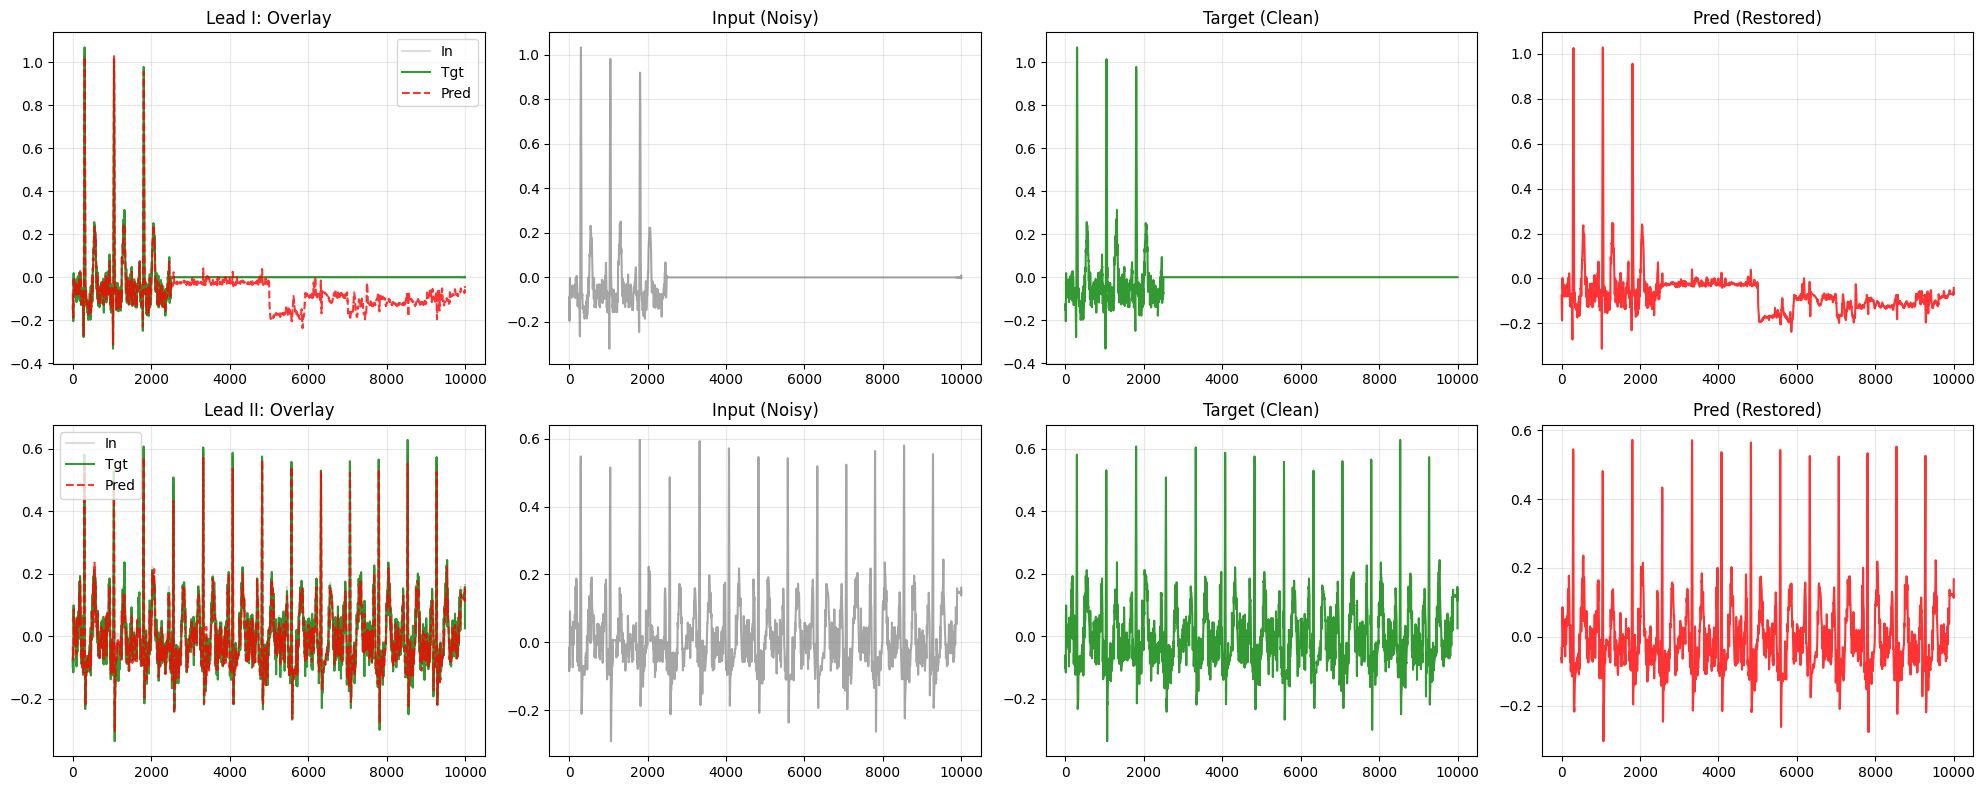


Sample Index: 3 | Original Length: 10000


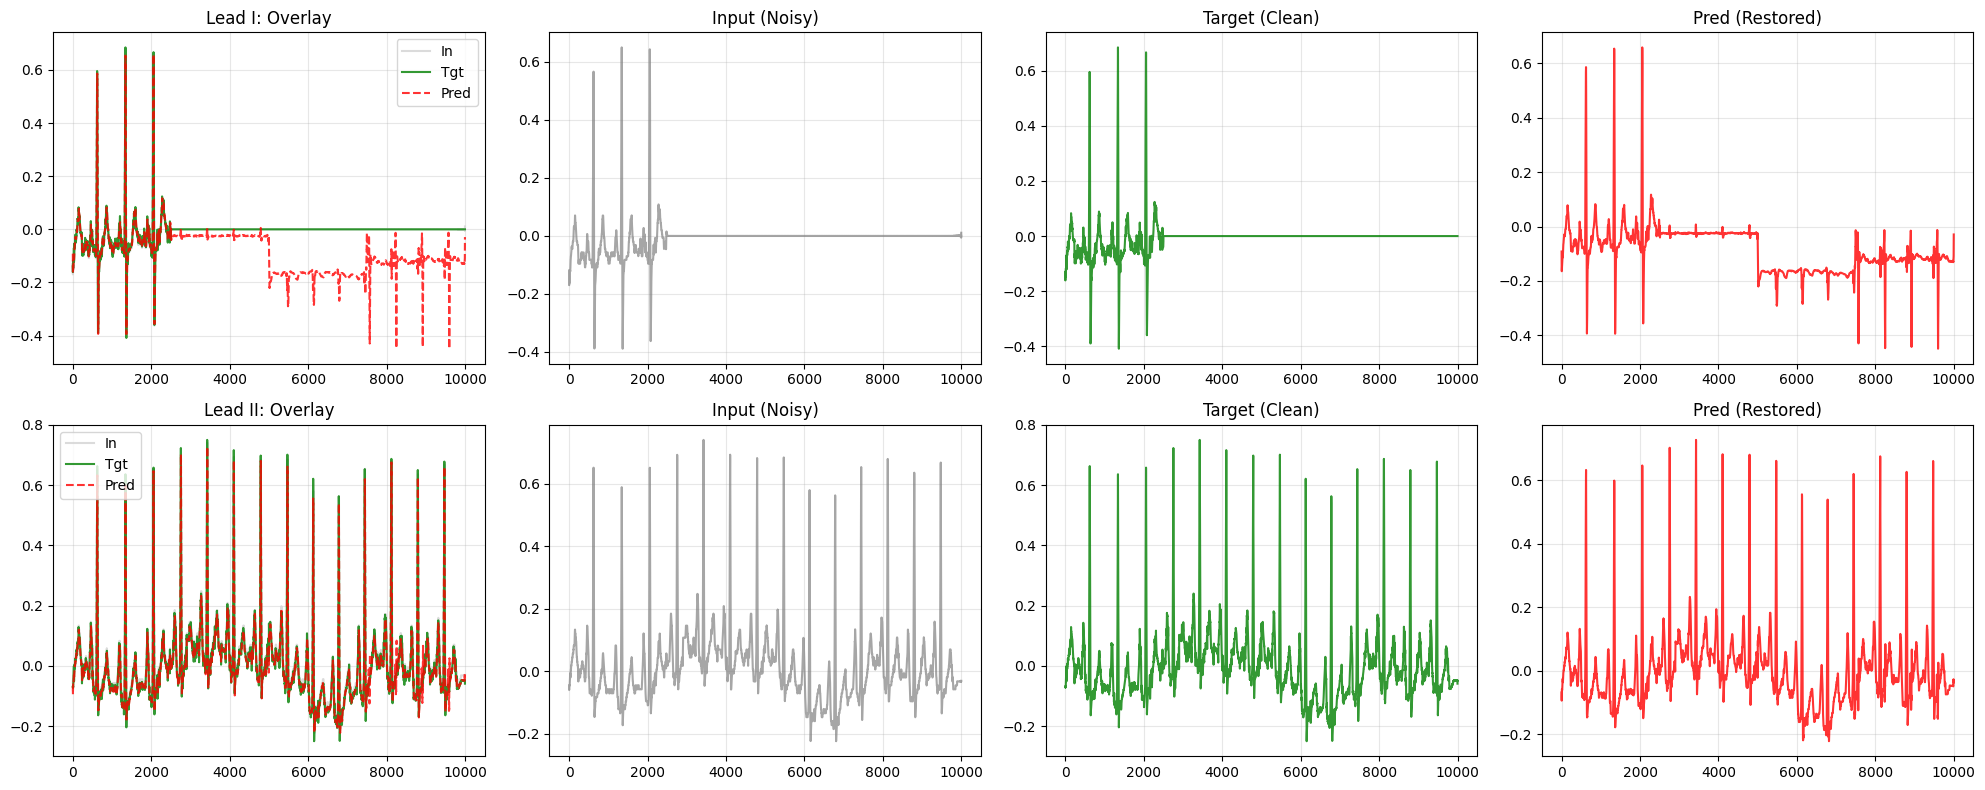


Sample Index: 1 | Original Length: 10000


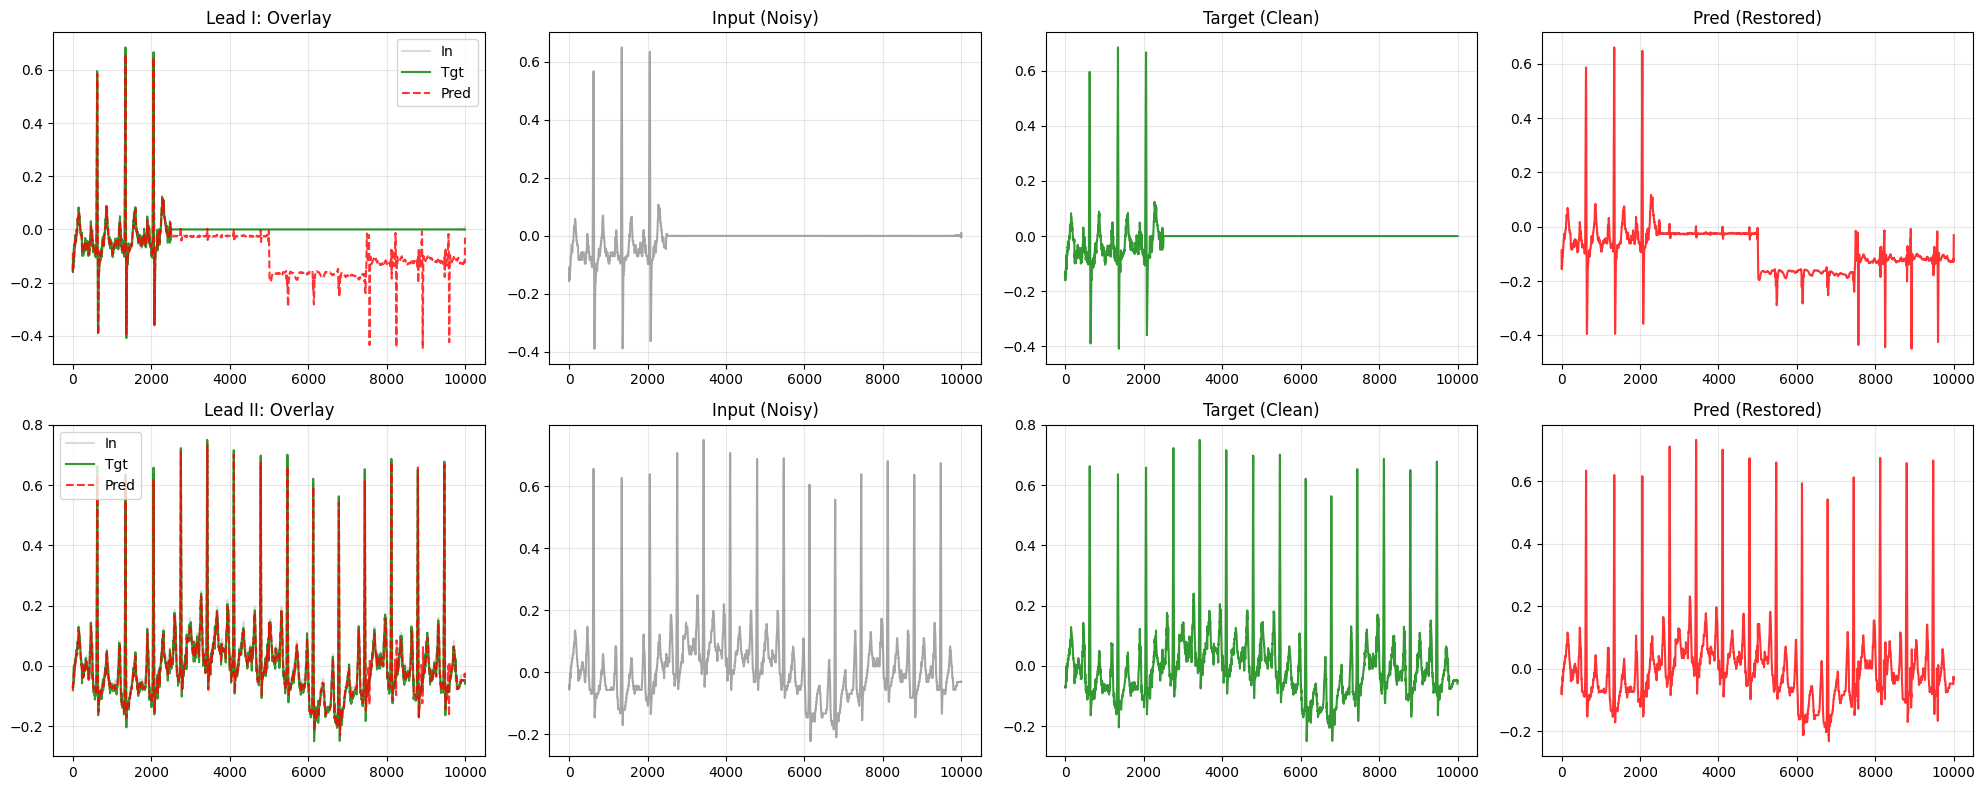

In [1]:
import os
import glob
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from scipy.signal import resample
from tqdm import tqdm

# =========================================================
# 0. 設定エリア
# =========================================================
BASE_DIR = r"C:\Users\fujiw\OneDrive\デスクトップ\ECG_ResNet"

STAGE2_DIR = os.path.join(BASE_DIR, "stage2")
CSV_DIR    = os.path.join(BASE_DIR, "train_csvs")
TRAIN_META = os.path.join(BASE_DIR, "train.csv")
SAVE_DIR   = os.path.join(BASE_DIR, "seeed30") 

FOLD_TO_LOAD = 0 
TARGET_LEN = 5000

# =========================================================
# 1. Dataset Class (変更なし: RAM版)
# =========================================================
class ECGDatasetRam(Dataset):
    def __init__(self, df, npy_dir, csv_dir, target_len=5000):
        self.target_len = target_len
        self.samples = [] 
        if not os.path.exists(npy_dir):
            raise FileNotFoundError(f"Directory not found: {npy_dir}")
            
        target_ids = set(df['id'].astype(str).tolist())
        file_list = []
        all_files = glob.glob(os.path.join(npy_dir, "*.npy"))
        
        # 
        for fpath in all_files:
            fname = os.path.basename(fpath)
            file_id = fname.split('-')[0]
            if file_id in target_ids:
                file_list.append((fpath, file_id))
        
        print(f"Loading data into RAM for visualization... ({len(file_list)} files)")
        
        for fpath, sample_id in tqdm(file_list, desc="Loading"):
            processed = self.process_one_file(fpath, sample_id, csv_dir)
            if processed is not None:
                self.samples.append(processed)

    def process_one_file(self, npy_path, sample_id, csv_dir):
        try:
            # Input Load
            data = np.load(npy_path)
            data = np.nan_to_num(data, nan=0.0)
            original_len = data.shape[1]
            if data.shape[0] != 13: return None

            reconstructed_sig = np.zeros((12, original_len), dtype=np.float32)
            reconstructed_conf = np.zeros((12, original_len), dtype=np.float32)

            for i in range(4):
                sig_row = data[i]
                conf_row = data[4+i]
                id_row = data[9+i]
                unique_ids = np.unique(id_row)
                for uid in unique_ids:
                    if 0 <= uid <= 11:
                        mask_ch = (id_row == uid)
                        reconstructed_sig[int(uid), mask_ch] = sig_row[mask_ch]
                        reconstructed_conf[int(uid), mask_ch] = conf_row[mask_ch]

            # Target Load
            csv_path = os.path.join(csv_dir, f"{sample_id}.csv")
            if not os.path.exists(csv_path): return None
            target_df = pd.read_csv(csv_path)
            target_vals = target_df.values.T 
            mask_data = (~np.isnan(target_vals)).astype(np.float32)
            target_data = np.nan_to_num(target_vals, nan=0.0)

            # Preprocessing
            if reconstructed_sig.shape[1] != self.target_len:
                input_sig_final = resample(reconstructed_sig, self.target_len, axis=1)
                input_conf_final = resample(reconstructed_conf, self.target_len, axis=1)
            else:
                input_sig_final = reconstructed_sig
                input_conf_final = reconstructed_conf

            # Concatenate
            input_final = np.concatenate([input_sig_final, input_conf_final], axis=0)

            return (np.nan_to_num(input_final).astype(np.float32), 
                    np.nan_to_num(target_data).astype(np.float32), 
                    (mask_data > 0.5).astype(np.float32), 
                    original_len)
        except:
            return None

    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        in_arr, tgt_arr, msk_arr, length = self.samples[idx]
        return (torch.from_numpy(in_arr), 
                torch.from_numpy(tgt_arr), 
                torch.from_numpy(msk_arr), 
                length)

# =========================================================
# 2. Model Class (変更なし)
# =========================================================
# 
class ResNet1d_UNet_Large(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc1 = nn.Sequential(nn.Conv1d(24, 128, 7, 2, 3), nn.BatchNorm1d(128), nn.ReLU()) 
        self.enc2 = nn.Sequential(nn.Conv1d(128, 256, 3, 2, 1), nn.BatchNorm1d(256), nn.ReLU()) 
        self.enc3 = nn.Sequential(nn.Conv1d(256, 512, 3, 2, 1), nn.BatchNorm1d(512), nn.ReLU()) 
        self.enc4 = nn.Sequential(nn.Conv1d(512, 1024, 3, 2, 1), nn.BatchNorm1d(1024), nn.ReLU())
        self.dec4 = nn.Sequential(nn.Conv1d(1024 + 512, 512, 3, 1, 1), nn.BatchNorm1d(512), nn.ReLU()) 
        self.dec3 = nn.Sequential(nn.Conv1d(512 + 256, 256, 3, 1, 1), nn.BatchNorm1d(256), nn.ReLU()) 
        self.dec2 = nn.Sequential(nn.Conv1d(256 + 128, 128, 3, 1, 1), nn.BatchNorm1d(128), nn.ReLU())
        self.dec1 = nn.Sequential(nn.Conv1d(128, 64, 3, 1, 1), nn.BatchNorm1d(64), nn.ReLU())
        self.final = nn.Conv1d(64, 12, 1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(e1)
        e3 = self.enc3(e2)
        e4 = self.enc4(e3)
        d4 = torch.cat([torch.nn.functional.interpolate(e4, size=e3.shape[2]), e3], dim=1)
        d4 = self.dec4(d4)
        d3 = torch.cat([torch.nn.functional.interpolate(d4, size=e2.shape[2]), e2], dim=1)
        d3 = self.dec3(d3)
        d2 = torch.cat([torch.nn.functional.interpolate(d3, size=e1.shape[2]), e1], dim=1)
        d2 = self.dec2(d2)
        d1 = torch.nn.functional.interpolate(d2, size=x.shape[2])
        d1 = self.dec1(d1)
        out = self.final(d1)
        input_signal = x[:, :12, :] 
        return input_signal + out

# =========================================================
# 3. Visualization Function (★修正箇所)
# =========================================================
def visualize_prediction(model, dataset, device, num_samples=3):
    """
    推論 -> 元の長さに復元 -> 重ね合わせと個別表示を実行
    """
    model.eval()
    
    indices = random.sample(range(len(dataset)), num_samples)
    
    for idx in indices:
        with torch.no_grad():
            # データ取得
            inputs, targets, masks, original_len = dataset[idx]
            
            # GPUへ (1, 24, 5000)
            input_tensor = inputs.unsqueeze(0).to(device)
            
            # 1. 推論 (Output: 1, 12, 5000)
            outputs = model(input_tensor)
            
            # 2. ★元の長さに復元 (Restore)
            pred_resized = F.interpolate(outputs, size=original_len, mode='linear', align_corners=False)
            
            # Numpy化
            input_wave = inputs[:12, :].numpy()  # 入力 (12, 5000)
            target_wave = targets.numpy()        # 正解 (12, L)
            pred_wave = pred_resized[0].cpu().numpy() # 予測 (12, L)
            
            # --- 3. 可視化 (Overlay + Separate) ---
            
            # 表示する誘導: I誘導(0)とII誘導(1)
            leads = [0, 1]
            lead_names = ["Lead I", "Lead II"]
            
            # 時間軸の作成 (X軸)
            x_input = np.linspace(0, original_len, 5000) # Input用
            x_orig = np.arange(original_len)             # Target/Pred用

            # 2行4列のグリッド (各行が1つの誘導: Overlay | Input | Target | Pred)
            fig, axes = plt.subplots(2, 4, figsize=(20, 8))
            
            print(f"\nSample Index: {idx} | Original Length: {original_len}")
            
            for i, ch in enumerate(leads):
                # (1) Overlay (重ね合わせ)
                ax_over = axes[i, 0]
                ax_over.plot(x_input, input_wave[ch], label="In", color='lightgray', alpha=0.8)
                ax_over.plot(x_orig, target_wave[ch], label="Tgt", color='green', alpha=0.8)
                ax_over.plot(x_orig, pred_wave[ch], label="Pred", color='red', linestyle='--', alpha=0.8)
                ax_over.set_title(f"{lead_names[i]}: Overlay")
                ax_over.legend()
                ax_over.grid(True, alpha=0.3)
                
                # (2) Input (Separate)
                ax_in = axes[i, 1]
                ax_in.plot(x_input, input_wave[ch], color='gray', alpha=0.7)
                ax_in.set_title("Input (Noisy)")
                ax_in.grid(True, alpha=0.3)
                
                # (3) Target (Separate)
                ax_tgt = axes[i, 2]
                ax_tgt.plot(x_orig, target_wave[ch], color='green', alpha=0.8)
                ax_tgt.set_title("Target (Clean)")
                ax_tgt.grid(True, alpha=0.3)
                
                # (4) Prediction (Separate)
                ax_pred = axes[i, 3]
                ax_pred.plot(x_orig, pred_wave[ch], color='red', alpha=0.8)
                ax_pred.set_title("Pred (Restored)")
                ax_pred.grid(True, alpha=0.3)

            plt.tight_layout()
            plt.show()

# =========================================================
# 4. Main Execution
# =========================================================
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using Device: {device}")

    # Dataset
    if os.path.exists(TRAIN_META):
        df = pd.read_csv(TRAIN_META)
        # 動作確認用に最初の500件だけロード (全件ならここを削除)
        df = df.iloc[:5] 
        dataset = ECGDatasetRam(df, STAGE2_DIR, CSV_DIR, target_len=TARGET_LEN)
    else:
        print("Error: train.csv not found.")
        exit()

    # Model
    model = ResNet1d_UNet_Large().to(device)
    
    # Load Weights
    model_path = os.path.join(SAVE_DIR, f"best_model_fold{FOLD_TO_LOAD}.pth")
    if os.path.exists(model_path):
        print(f"Loading weights from: {model_path}")
        model.load_state_dict(torch.load(model_path, map_location=device))
    else:
        print(f"Error: Model file not found at {model_path}")
        exit()

    # Run Visualization
    print("Visualizing predictions...")
    visualize_prediction(model, dataset, device, num_samples=3)